<h1 style="font-size: 40px; margin-bottom: 0px;">15.1 Multiomics: Integrating ChIP-seq and RNA-seq</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 950px;"></hr>

We've taken a look at the TAZ-TEAD-DNA binding interactions through ChIP-seq analysis, and we identified a set of reproducible peaks where TAZ-TEAD are likely to bind to DNA. Our analysis showed that TAZ-TEAD primarily bind to regions distant from the transcription start site (TSS) rather than the nearby promoter region, suggesting a longer range regulation of target gene expression through distant enhancers. Then we explored the transcriptional changes resulting from TAZ KO through RNA-seq, and we performed differential expression analysis to determine which genes are impacted by TAZ KO and if this can explain the phenotypes we observed in MCB201A. 

In this lesson, we'll be taking a basic multiomics approach by integrating our two big data analyses together in order to identify overlapping sets of genes from our two analyses. This approach can give us insight into the regulation of TAZ target genes and potentially identify some direct targets of TAZ and determine how TAZ regulates their transcription.

<strong>Learning objectives:</strong>

<ul>
    <li>Use HOMER to label ChIP-seq peaks with associated genes</li>
    <li>Continue practice working with data in Python</li>
    <li>Continue practicing data visualization</li>
    <li>Continue practicing statistical analysis and functional analysis</li>
</ul>

<h1>Annotate ChIP-seq peaks based on nearest TSS method</h1>

A common way of annotating peaks that we've made use of before is to determine the closest TSS to a significant peak and then assign that TSS's gene to the peak (nearest TSS method). This works well with annotating peaks in promoter regions since promoters regulate transcription at a much shorter distance from the TSS, and this generally works well for enhancer regions as well. However, there is the caveat that enhancer regions can act at very long distances, where there are intervening genes between their target TSS and the enhancer region. Additionally, some enhancers may act on multiple genes, or multiple enhancers can regulate a single gene. These situations can complicate annotating peaks via the nearest TSS method, and other functional genomics approaches can get around this issue.

To annotate peaks based on the nearest TSS, we can return to HOMER's <code>annotatePeaks.pl</code> command. Included in today's lesson is a .narrowPeak file containing merged peaks from the full ChIP-seq dataset. Instead of just the peaks that are in the top 500 in both replicates, this file contains peaks present in the top 2500 in both replicates. We'll pass this file to HOMER to annotate based on the nearest TSS:

<h2>Set up HOMER</h2>

Change to your HOMER directory.

<pre style="width: 450px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">cd ~/homer</pre>

Then update your PATH, so that Terminal can find where all the HOMER files are:

<pre style="width: 450px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">PATH=$PATH:/home/jovyan/homer/.//bin/</pre>

<h2>Annotate the concordant ChIP-seq peaks</h2>

Change to your Week 15 directory:

<pre style="width: 450px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">cd ~/MCB201B_F2024/Week_15</pre>

Then annotate peaks using <code>annotatePeaks.pl</code>

<pre style="width: 450px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">annotatePeaks.pl \
./top_concordant_peaks_full-set.narrowPeak \
hg19 \
-noann \
> ./annotated-peaks-full-set.txt</pre>

<h1>Install and import packages needed for today</h1>

In [1]:
pip install matplotlib-venn

  Using cached matplotlib_venn-1.1.1-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install gseapy

  Using cached gseapy-1.1.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (548 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_venn as vn
import seaborn as sns
import scipy.stats as stats
import gseapy as gp

<h1>Exercise #1: Load in your annotated peaks and pull out the gene names</h1>

For this exercise, load in your annotated peaks file then generate a set (the data type) of gene names that correspond to peaks annotated to a protein-coding gene.

In [4]:
peaks = pd.read_csv('~/MCB201B_F2024/Week_15/data/annotated-peaks-full-set.txt',
                    delimiter='\t'
                   )

Let's take a look to make sure the data imported properly:

In [5]:
peaks

,PeakID (cmd=annotatePeaks.pl ./top_concordant_peaks_full-set.narrowPeak hg19 -noann),Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,Entrez ID,Nearest Unigene,Nearest Refseq,Nearest Ensembl,Gene Name,Gene Alias,Gene Description,Gene Type
0,Merged-chr13-90167064-2,chr13,90166997,90167132,+,0.0,/home/jovyan/shared/course/mcb201b-shared/chip...,NaN,NaN,-14301,NR_131228,105370308.0,NaN,NR_131228,ENSG00000226037,LINC01040,TCONS_00021682,long intergenic non-protein coding RNA 1040,ncRNA
1,Merged-chr3-106941951-2,chr3,106941895,106942007,+,0.0,/home/jovyan/shared/course/mcb201b-shared/chip...,NaN,NaN,17534,NR_028303,100302640.0,NaN,NR_028303,NaN,LINC00882,-,long intergenic non-protein coding RNA 882,ncRNA
2,Merged-chr10-8408430-2,chr10,8408374,8408486,+,0.0,/home/jovyan/shared/course/mcb201b-shared/chip...,NaN,NaN,-98162,NR_108058,100507143.0,NaN,NR_108058,ENSG00000232170,LINC00708,GS1-756B1.2,long intergenic non-protein coding RNA 708,ncRNA
3,Merged-chr11-69064943-2,chr11,69064851,69065036,+,0.0,/home/jovyan/shared/course/mcb201b-shared/chip...,NaN,NaN,3321,NM_138768,26579.0,NaN,NM_138768,ENSG00000172927,MYEOV,OCIM,myeloma overexpressed,protein-coding
4,Merged-chr4-183006351-2,chr4,183006291,183006412,+,0.0,/home/jovyan/shared/course/mcb201b-shared/chip...,NaN,NaN,59317,NR_027107,90768.0,NaN,NR_027107,NaN,TENM3-AS1,-,TENM3 antisense RNA 1,ncRNA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864,Merged-chr5-148637654-2,chr5,148637590,148637718,+,0.0,/home/jovyan/shared/course/mcb201b-shared/chip...,NaN,NaN,-13747,NM_001323063,134265.0,NaN,NM_152406,ENSG00000157510,AFAP1L1,-,actin filament associated protein 1 like 1,protein-coding
1865,Merged-chr15-67066818-2,chr15,67066760,67066876,+,0.0,/home/jovyan/shared/course/mcb201b-shared/chip...,NaN,NaN,72244,NR_027654,4091.0,NaN,NM_005585,ENSG00000137834,SMAD6,AOVD2|HsT17432|MADH6|MADH7,SMAD family member 6,protein-coding
1866,Merged-chr9-132096553-2,chr9,132096500,132096606,+,0.0,/home/jovyan/shared/course/mcb201b-shared/chip...,NaN,NaN,-2649,NR_120685,100506119.0,NaN,NR_120685,ENSG00000233901,LINC01503,-,long intergenic non-protein coding RNA 1503,ncRNA
1867,Merged-chr19-1383556-2,chr19,1383499,1383613,+,0.0,/home/jovyan/shared/course/mcb201b-shared/chip...,NaN,NaN,-350,NM_001363602,374291.0,NaN,NM_024407,ENSG00000115286,NDUFS7,CI-20|CI-20KD|MC1DN3|MY017|PSST,NADH:ubiquinone oxidoreductase core subunit S7,protein-coding


Now, see if you can pull out the gene names corresponding to protein-coding genes from our dataset.

In [6]:
chip_genes_only = set(peaks.loc[peaks['Gene Type'] == 'protein-coding', 'Gene Name'])

In [19]:
# peaks.sort_values(by='Gene Name', inplace=True)

In [9]:
type(chip_genes_only)

set

What additional modification can you make to the code line above to at the same time convert your data type to a set?

Let's take a quick look at our data:

In [ ]:
print(chip_genes_only)

<h1>Exercise #2: Load in your DESeq2 results</h1>

Let's load in our RNA-seq results, so that we can begin looking for the intersection between our two 'omics datasets. With today's lesson is also a .csv file containing the full results table for our class's complete RNA-seq analysis that you can load into this notebook.

In [11]:
res = pd.read_csv('~/MCB201B_F2024/Week_15/data/FULL_class_shrinklfc.csv',
                  delimiter=','
                 )
res

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,pvalue,padj
0,A1BG,45.839060,0.378054,0.154459,9.923922e-03,2.259179e-02
1,A1BG-AS1,85.522729,-0.236626,0.109599,2.664203e-02,5.464498e-02
2,A1CF,1.160615,-0.139528,0.476157,4.944840e-01,6.173993e-01
3,A2M,5.078312,-4.007561,0.789058,6.944742e-08,3.406992e-07
4,A2M-AS1,7.659644,-2.015787,0.409586,9.407784e-08,4.547941e-07
...,...,...,...,...,...,...
26694,ZYG11B,1982.334467,0.252273,0.070220,2.824015e-04,8.476771e-04
26695,ZYX,4601.997910,0.299994,0.050487,2.319737e-09,1.353358e-08
26696,ZZEF1,1780.570501,-0.028827,0.074017,6.927621e-01,7.856268e-01
26697,ZZZ3,3633.187232,-0.219761,0.105782,3.333959e-02,6.658681e-02


Let's also rename the <code>Unnamed: 0</code> column header to <code>gene</code>, to make things easier for us later when we're merging our DataFrames.

In [12]:
res.rename(columns={'Unnamed: 0' : 'gene'}, inplace=True)

Take a quick look at your DataFrame to make sure everything looks okay:

In [13]:
res

,gene,baseMean,log2FoldChange,lfcSE,pvalue,padj
0,A1BG,45.839060,0.378054,0.154459,9.923922e-03,2.259179e-02
1,A1BG-AS1,85.522729,-0.236626,0.109599,2.664203e-02,5.464498e-02
2,A1CF,1.160615,-0.139528,0.476157,4.944840e-01,6.173993e-01
3,A2M,5.078312,-4.007561,0.789058,6.944742e-08,3.406992e-07
4,A2M-AS1,7.659644,-2.015787,0.409586,9.407784e-08,4.547941e-07
...,...,...,...,...,...,...
26694,ZYG11B,1982.334467,0.252273,0.070220,2.824015e-04,8.476771e-04
26695,ZYX,4601.997910,0.299994,0.050487,2.319737e-09,1.353358e-08
26696,ZZEF1,1780.570501,-0.028827,0.074017,6.927621e-01,7.856268e-01
26697,ZZZ3,3633.187232,-0.219761,0.105782,3.333959e-02,6.658681e-02


<h1>Guided Exercise: Pull out genes from DESeq results</h1>

Let's then take a look at our DESeq2 results to remove the genes that were filtered out by DESeq2's independent filtering method. In short, these genes were identified as having a mean normalized count that is too low, and as a result, the high dispersion of these genes make it very unlikely that these genes will be significant and are removed. While they will still have a calculated log2FoldChange, they will not have a adjusted p-value, so those values will be set to <code>NaN</code>.

More detailed information on independent filtering can be found in <a href="https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#indfilttheory" rel="noopener noreferrer" target="_blank"><u>the DESeq2 vignette.</u></a>

There are also additional filters that DESeq2 applies to filter out other genes based on if the gene is not expressed in any sample (zero counts in in all samples) or if there is an extreme outlier present in one of the samples. These filters help to increase the detection power of DESeq2 without really changing the probability of a type I error.

<h2>Identify genes filtered out by DESeq2</h2>

We can determine how many genes were filtered out by counting how many <code>NaN</code> are present in the DataFrame.

In [15]:
res.isna().value_counts()

gene   baseMean  log2FoldChange  lfcSE  pvalue  padj 
False  False     False           False  False   False    21522
                                                True      5177
dtype: int64

We can see that no genes were filtered out based on an absence of expression in all samples because we had already done that prior to providing DESeq2 with our counts matrix. We can also see that a number of genes have been filtered out due to their low mean normalized counts based on the number of <code>NaN</code> in the adjusted p-values column.

<h2>Pull out gene names for genes that pass the filter</h2>

We can drop the rows containing <code>NaN</code>, which will allow us to focus just on those genes that passed the filter and use those to identify overlaps with our ChIP-seq peaks.

In [20]:
res_genes_only = set(res.dropna()['gene'])

In [ ]:
res_genes_only

<h2>Pull out gene names for significant hits</h2>

We can also pull out just the significant hits identified by DESeq2 to narrow down our set of genes to those that are differentially expressed when we KO TAZ.

In [22]:
sig_hits_genes_only = set(res.loc[res['padj'] <= 0.05, 'gene'])

In [ ]:
sig_hits_genes_only

<h1>Guided: Exercise: Create a venn diagram of ChIP-seq and RNA-seq results</h1>

Now let's create a venn diagram to see how our two analyses overlap. To do this, we'll make use of the matplotlib_venn package that we imported. <a href="https://pypi.org/project/matplotlib-venn/" rel="noopener noreferrer" target="_blank"><u>Documentation is here.</u></a>

We can start with a simple venn diagram, and then pull out elements from it to modify the style of our figure.

```
venn_diag = vn.venn2((chip_genes_only, sig_hits_genes_only), 
                     set_labels=('ChIP Peaks', 'RNA-seq DE'))
```

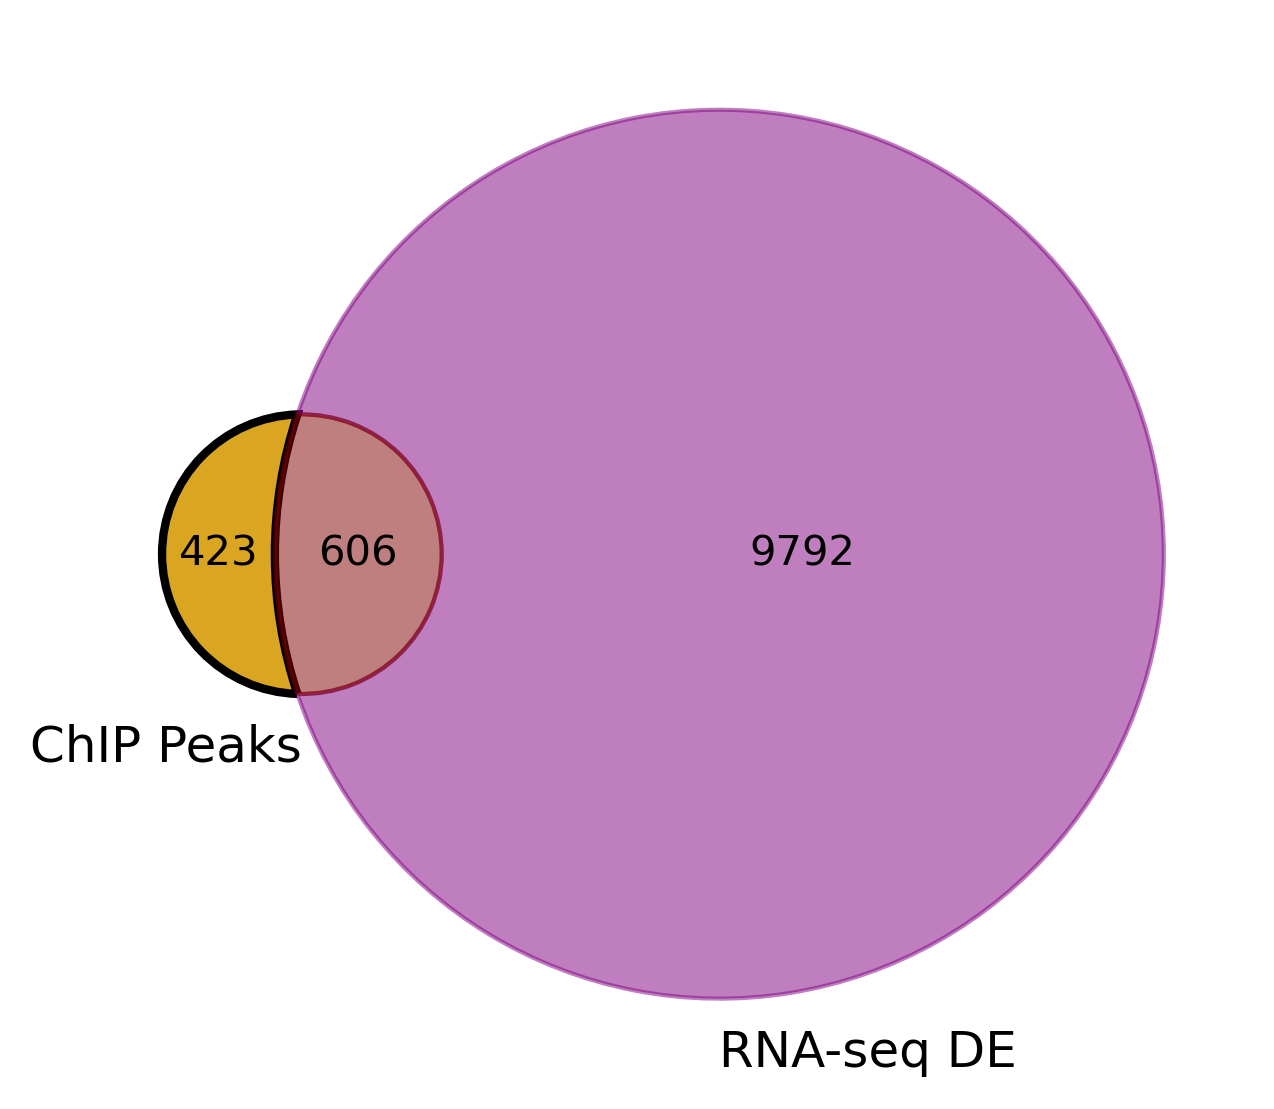

In [34]:
fig, ax = plt.subplots()

venn_diag = vn.venn2((chip_genes_only, sig_hits_genes_only), 
                     set_labels=('ChIP Peaks', 'RNA-seq DE'))

venn_diag.get_patch_by_id('10').set_color('goldenrod')
venn_diag.get_patch_by_id('10').set_alpha(1)
venn_diag.get_patch_by_id('10').set_edgecolor('k')
venn_diag.get_patch_by_id('10').set_lw(2)
venn_diag.get_patch_by_id('11').set_color('maroon')
venn_diag.get_patch_by_id('11').set_alpha(0.5)
venn_diag.get_patch_by_id('01').set_color('purple')
venn_diag.get_patch_by_id('01').set_alpha(0.5)

fig.set_dpi(300)
fig.set_size_inches(5,5)

fig.savefig('blah.pdf')

We can see that our two groups do share some overlapping genes, but not all the genes actually overlap. As Dr. Ingolia talked about in lecture this week, there are additional considerations to keep in mind that can inform how we interpret our results. A direct target is likely to be found in both groups, whereas indirect targets may be a significant hit from our DESeq2 analysis, but it may not have an associated ChIP-seq peak. On the other hand, additional layers of transcriptional regulation may result in a ChIP-seq peak whose associated gene is not differentially expressed.

<h1>Guided Exercise: Identify overlapping genes between both sets</h1>

Now that we have an idea of the numbers of overlapping and non-overlapping genes between our two groups, let's take a look at which genes are in each group. We've generated a set data type object that contains the names of the genes from our ChIP-seq peaks and the names of the genes from our differential expression analysis. To identify overlapping genes, we can make use of set operators.

In [ ]:
chip_genes_only & res_genes_only

We can also use this set to create a DataFrame that has a column named <code>gene</code> that has all the shared genes between our two analyses.

In [39]:
overlap = pd.DataFrame(chip_genes_only & res_genes_only,
                       columns=['gene']
                      )

Let's take a look at our DataFrame object containing our overlapping genes:

In [40]:
overlap

,gene
0,MUSK
1,BCAR1
2,ATAD2
3,TGM2
4,CLIC4
...,...
933,SLC20A2
934,INPP4B
935,TOX2
936,SOST


<h1>Guided Exercise: Pull in DESeq2 results for overlapping genes</h1>

Let's merge our data contained in our DESeq2 results with our overlapping genes. This will allow us to look at the distribution of our log2 fold changes

In [41]:
overlap_res_info = overlap.merge(res,
                                 how='inner',
                                 on='gene'
                                )

In [42]:
overlap_res_info

,gene,baseMean,log2FoldChange,lfcSE,pvalue,padj
0,MUSK,940.556841,-0.077334,0.091304,3.857820e-01,5.167707e-01
1,BCAR1,2717.721726,0.299069,0.055223,5.008190e-08,2.501422e-07
2,ATAD2,12746.477463,0.270557,0.062737,1.371249e-05,5.013936e-05
3,TGM2,24716.273179,0.144822,0.069924,4.145738e-02,8.068781e-02
4,CLIC4,21779.209873,-0.411549,0.081315,2.691550e-07,1.227798e-06
...,...,...,...,...,...,...
933,SLC20A2,947.948777,-0.061296,0.045140,1.725097e-01,2.742873e-01
934,INPP4B,2727.060861,0.209295,0.076459,5.617715e-03,1.348628e-02
935,TOX2,971.016598,-0.662554,0.068533,1.666482e-22,2.947085e-21
936,SOST,149.321670,0.170585,0.097812,7.527792e-02,1.362485e-01


Now let's take the log2 fold change data and create a histogram to take a look at the distribution of expression changes for these genes.

<Axes: xlabel='log2FoldChange', ylabel='Count'>

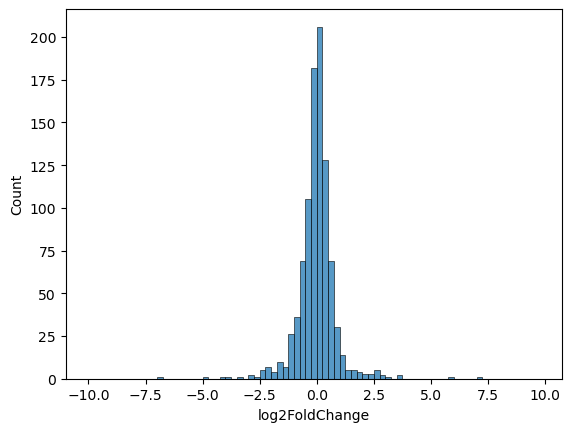

In [43]:
sns.histplot(overlap_res_info['log2FoldChange'],
             bins=np.arange(-10, 10, 0.25)
            )

<h1>Exercise #3: Pull out results for genes not corresponding to a peak</h1>

For this exercise, see if you can identify the genes that do not correspond to a ChIP-seq peak and pull out the DESeq2 results for those genes.

In [45]:
no_overlap = pd.DataFrame(res_genes_only - chip_genes_only,
                          columns=['gene']
                         )

no_overlap_res_info = no_overlap.merge(res,
                                       how='inner',
                                       on='gene'
                                      )

In [46]:
no_overlap_res_info

,gene,baseMean,log2FoldChange,lfcSE,pvalue,padj
0,MIR3682,17.289805,0.272749,0.241419,1.983749e-01,3.077063e-01
1,HILPDA,424.644304,0.452417,0.083354,3.579598e-08,1.825162e-07
2,PKD1P3,9.722250,-0.003699,0.275794,9.862968e-01,9.917806e-01
3,CAPNS1,10540.499693,0.018034,0.055271,7.440782e-01,8.249562e-01
4,LOC100420644,33.221995,-0.063909,0.247845,7.660995e-01,8.423416e-01
...,...,...,...,...,...,...
20579,USP54,932.613893,-0.079785,0.051582,1.200017e-01,2.029927e-01
20580,IGKC,23.546498,-2.678975,0.269344,2.542046e-24,4.978153e-23
20581,AP3B1,3716.525408,-0.036267,0.042176,3.878186e-01,5.186103e-01
20582,LOC105369747,3.924944,-1.529519,0.744439,2.994752e-03,7.564025e-03


<h1>Exercise #4: Plot distribution of log2 fold change</h1>

Once you've identified and pulled the information for genes that did not correspond to a ChIP-seq peak, generate a histogram of the distribution of log2 fold change values. Use the same bin set-up as we used for the overlapping genes, so we can visually compare the two subsets of our data.

<Axes: xlabel='log2FoldChange', ylabel='Count'>

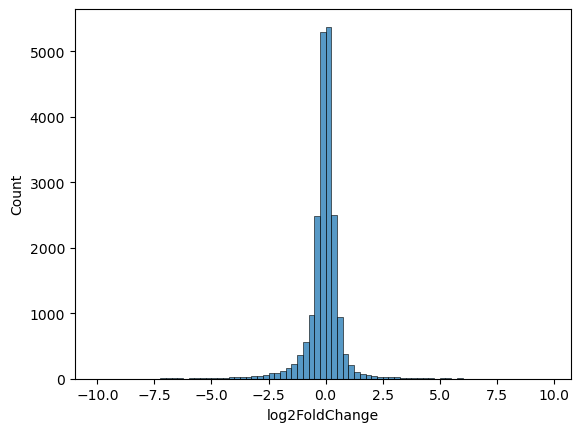

In [47]:
sns.histplot(no_overlap_res_info['log2FoldChange'],
             bins=np.arange(-10, 10, 0.25)
            )

<h1>Exercise #5: Determine if there is a statistical difference between the distribution of the two sets of data</h1>

There looks like maybe there's a minor difference in the distribution of our two subsets of data. For this exercise, you'll make use of the scipy.stats package to determine if there is a stastically significant difference in the distribution of their log2 fold change values.

In [48]:
stats.mannwhitneyu(no_overlap_res_info['log2FoldChange'],
                   overlap_res_info['log2FoldChange']
                  )

MannwhitneyuResult(statistic=9269935.0, pvalue=0.039085449166501356)

<h1>Determine functional group enrichment in TAZ direct targets</h1>

With our subsetted data, we can perform an over-representation analysis or GSEA to determine which functional groups TAZ may be directly or indirectly regulating. 

First, let's prepare our gene sets from MSigDB Hallmark collection for use in functional analysis:

In [50]:
msig = gp.Msigdb()
hallmark_db = msig.get_gmt(category='h.all', dbver='2024.1.Hs')

In [ ]:
hallmark_db

<h2>Perform over-representation analysis</h2>

Then we can prepare our set of background genes based on the genes present in our DESeq2 results DataFrame for an over-representation analysis.

In [54]:
bg_genes = res['gene'].to_list()

In [ ]:
bg_genes

Now we can define what our "interesting" genes are that we want to determine what gene sets or functional groups are enriched:

In [67]:
interesting_genes = no_overlap_res_info.loc[(no_overlap_res_info['padj'] <= 0.05) & (no_overlap_res_info['log2FoldChange'].abs() >= 1), 'gene'].to_list()

In [ ]:
interesting_genes

Let's run the over-representation analysis using the GSEApy package's <code>gp.enrich()</code> function.

In [69]:
ora = gp.enrich(gene_list=interesting_genes,
                gene_sets=hallmark_db,
                background=bg_genes
               )

Now let's take a look at the output of our analysis:

In [70]:
ora.res2d

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
0,gs_ind_0,HALLMARK_ADIPOGENESIS,11/195,8.984918e-01,9.999999e-01,0.738675,7.906600e-02,UCP2;DHCR7;PLIN2;MYLK;COL15A1;EPHX2;LAMA4;SORB...
1,gs_ind_0,HALLMARK_ALLOGRAFT_REJECTION,29/179,1.247209e-04,4.896551e-04,2.346647,2.109502e+01,NCF4;IL12A;IL6;CCL5;ITK;CTSS;IL1B;CCR2;SOCS1;F...
2,gs_ind_0,HALLMARK_ANDROGEN_RESPONSE,14/99,2.063829e-02,4.690519e-02,2.020883,7.842254e+00,BMPR1B;STEAP4;H1-0;TSC22D1;SELENOP;PTK2B;IQGAP...
3,gs_ind_0,HALLMARK_ANGIOGENESIS,9/35,1.113345e-03,3.479204e-03,4.271759,2.904961e+01,JAG2;THBD;CCND2;SLCO2A1;VCAN;S100A4;VTN;OLR1;V...
4,gs_ind_0,HALLMARK_APICAL_JUNCTION,24/192,1.408197e-02,3.352849e-02,1.735194,7.396890e+00,CLDN4;ICAM2;ADAM23;CADM2;CNN2;TRO;TRAF1;MMP9;D...
5,gs_ind_0,HALLMARK_APICAL_SURFACE,5/41,2.102301e-01,3.185305e-01,1.791355,2.793712e+00,PKHD1;RTN4RL1;THY1;MDGA1;HSPB1
6,gs_ind_0,HALLMARK_APOPTOSIS,31/159,1.599464e-06,1.599464e-05,2.940254,3.924017e+01,TNFSF10;FEZ1;CLU;IL6;LEF1;BTG2;HSPB1;IL1B;H1-0...
7,gs_ind_0,HALLMARK_BILE_ACID_METABOLISM,13/109,7.980010e-02,1.596002e-01,1.665483,4.210725e+00,HSD3B1;CH25H;CYP7B1;BMP6;NR3C2;RBP1;SULT1B1;AB...
8,gs_ind_0,HALLMARK_CHOLESTEROL_HOMEOSTASIS,10/73,5.504915e-02,1.146857e-01,1.968346,5.707275e+00,TRIB3;MAL2;ATF3;LSS;CLU;SEMA3B;DHCR7;ERRFI1;SC...
9,gs_ind_0,HALLMARK_COAGULATION,26/126,3.643875e-06,2.765308e-05,3.158577,3.955316e+01,CLU;S100A1;MAFF;CRIP2;PDGFB;PROS1;F2;MMP9;THBS...


We can sort our data by the adjusted p-value just to reorganize our data where the most significant over-representation is at the top of the DataFrame:

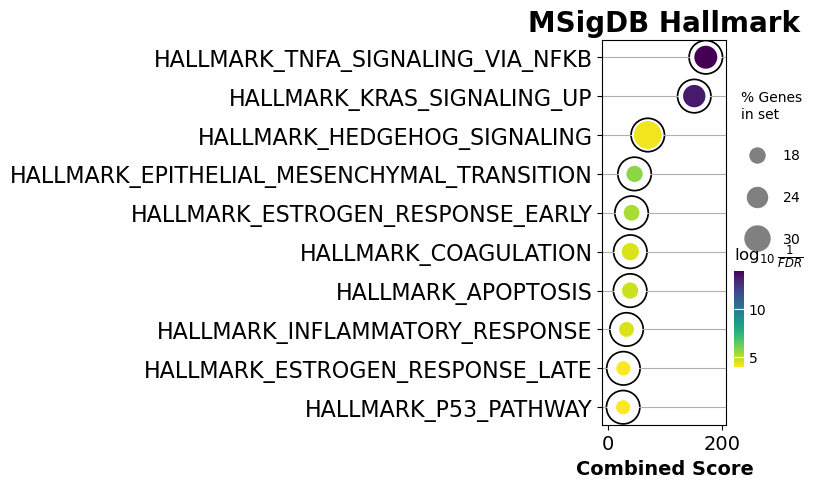

In [75]:
gp.dotplot(df=ora.res2d,
           column='Adjusted P-value',
           x='Combined Score',
           y='Term',
           top_term=10,
           cutoff=0.05,
           size=10,
           figsize=(2, 5),
           title = 'MSigDB Hallmark',
           xticklabels_rot = 0,
           show_ring=True,
           marker='o'
          );

<h2>Generate a dot plot of over-represented gene sets</h2>

We can make use of the <code>gp.dotplot()</code> function to generate a dot plot of our over-representation analysis results.

What adjustments can we make to our code to instead look at the set of genes that are indirectly regulated by TAZ?

<h1>Perform GSEA on overlapping genes</h1>

Like with over-representation analysis, we can also perform GSEA on our overlapping genes to get an idea of what functional groups may be direct targets of TAZ by taking a look at the difference in enrichment between our TAZ KO and control samples. 

First, we can prepare our counts matrix to pass to GSEApy's <code>gp.GSEA()</code> function:

In [76]:
counts = pd.read_csv('~/MCB201B_F2024/Week_15/data/FULL_class_norm_counts.csv',
                     delimiter=','
                    )

We can rename our <code>Unnamed: 0</code> column to <code>gene</code>, so that it's easier for us to merge our DataFrames:

In [77]:
counts.rename(columns={'Unnamed: 0' : 'gene'}, inplace=True)

In [78]:
counts

,gene,1M_g1_control,1M_g1_tazko,1M_g2_control,1M_g2_tazko,1M_g3_control,1M_g3_tazko,1M_g4_control,1M_g4_tazko,1M_g5_control,1M_g5_tazko,1M_g6_control,1M_g6_tazko,1M_g7_control,1M_g7_tazko,1M_g8_control,1M_g8_tazko
0,A1BG,32.593465,45.011770,42.839504,71.017649,38.705897,37.561944,39.721825,57.699751,40.138484,62.055365,31.886614,57.646645,49.679992,49.497385,39.023018,38.345656
1,A1BG-AS1,107.657204,79.432535,97.281374,78.002992,85.878709,78.976395,105.924868,97.736313,97.001336,58.789294,83.098447,80.506522,78.494388,80.909187,84.932452,73.741646
2,A1CF,2.963042,0.000000,0.000000,0.000000,0.000000,2.889380,2.206768,1.177546,0.836218,0.000000,0.966261,1.987815,0.000000,0.951873,4.590943,0.000000
3,A2M,7.901446,0.000000,7.139917,0.000000,15.724271,0.000000,7.723688,0.000000,12.543276,0.000000,6.763827,0.000000,13.910398,3.807491,5.738679,0.000000
4,A2M-AS1,10.864488,5.295502,10.709876,2.328448,14.514711,1.926254,11.033840,2.355092,8.362184,3.266072,20.291481,1.987815,10.929598,0.000000,13.772830,4.916110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26694,ZYG11B,1751.158009,2191.455384,1693.945385,2165.456197,1751.441831,2406.853795,2096.429672,2379.820354,1899.888243,2239.708783,1575.971716,1942.095605,1940.500491,2191.211171,1742.262997,1749.151846
26695,ZYX,4337.893951,5286.676500,4536.524968,5117.927657,4142.740518,5036.189874,3902.669343,4924.497140,4168.548808,5117.118097,4327.883087,5648.377341,3834.301790,4539.481353,3716.368632,4994.767497
26696,ZZEF1,1691.897163,1646.901227,1763.559578,1541.432261,1713.945493,1845.350889,1888.993473,1568.491198,1772.783044,1735.917197,1686.125471,1661.813640,1763.639719,2263.553504,2112.981671,1831.742489
26697,ZZZ3,4957.169796,3478.262452,4693.603149,3326.187287,4003.641202,3452.809466,4336.299270,3726.932915,4196.144015,3498.779487,3542.312882,3120.870113,2820.829951,3286.816757,2815.396002,2874.940976


We already have our DataFrame containing our set of overlapping genes, so let's use that to pull the count information as a new DataFrame:

In [79]:
overlap_counts = overlap.merge(counts,
                               how='inner',
                               on='gene'
                              )

Like before, we can generate our own variables that would have been created by the .cls parser.

In [80]:
ctrl = 'CONTROL'
tazko = 'TAZ KO'
class_vector = ([ctrl] + [tazko]) * 8

In [81]:
print(ctrl)
print(tazko)
print(class_vector)

CONTROL
TAZ KO
['CONTROL', 'TAZ KO', 'CONTROL', 'TAZ KO', 'CONTROL', 'TAZ KO', 'CONTROL', 'TAZ KO', 'CONTROL', 'TAZ KO', 'CONTROL', 'TAZ KO', 'CONTROL', 'TAZ KO', 'CONTROL', 'TAZ KO']


Now we can run a GSEA on the genes from our RNA-seq results that overlap with our ChIP-seq results as another way to identify enrichment and to glean information on the change relative to our controls.

In [82]:
gs_res = gp.GSEA(data=overlap_counts,
                 gene_sets=hallmark_db,
                 classes=class_vector,
                 method='signal_to_noise',
                 permutation_type='phenotype',
                 permutation_num=1000,
                 seed=135
                )

gs_res.pheno_pos = tazko
gs_res.pheno_neg = ctrl
gs_res.run()

Let's sort our output DataFrame by the FDR, so we can see the significant hits at the top of the DataFrame.

In [84]:
gs_res.res2d.sort_values(by='FDR q-val', inplace=True)

In [85]:
gs_res.res2d

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,HALLMARK_KRAS_SIGNALING_UP,-0.643455,-1.635321,0.008065,0.114321,0.109328,10/18,14.07%,ITGB2;SATB1;DUSP6;PLAU;ETS1;CSF2;PTCD2;IGFBP3;...
1,gsea,HALLMARK_TNFA_SIGNALING_VIA_NFKB,-0.665124,-1.517705,0.005917,0.126767,0.210632,21/28,26.23%,STAT5A;FOSB;LAMB3;JAG1;IFIT2;PLAU;SOCS3;TNIP1;...
2,gsea,HALLMARK_IL2_STAT5_SIGNALING,-0.544315,-1.368291,0.07529,0.212661,0.427282,12/18,25.16%,SPRED2;CSF2;PHLDA1;SOCS2;GADD45B;NRP1;KLF6;ARL...
7,gsea,HALLMARK_ESTROGEN_RESPONSE_LATE,-0.286405,-1.044338,0.405462,0.515181,0.85657,8/15,43.60%,LAMC2;NCOR2;KLF4;MYOF;BCL2;TNNC1;FLNB;CCND1
5,gsea,HALLMARK_ESTROGEN_RESPONSE_EARLY,0.278744,1.213711,0.154618,0.543797,0.681,12/24,37.53%,WWC1;SLC2A1;ESRP2;PODXL;PRSS23;FKBP5;TOB1;ALDH...
9,gsea,HALLMARK_INTERFERON_GAMMA_RESPONSE,-0.334313,-0.935837,0.558943,0.564229,0.938816,6/15,19.83%,IFIT2;SLAMF7;SOCS3;LATS2;ARL4A;UPP1
6,gsea,HALLMARK_MYOGENESIS,-0.360187,-1.058561,0.394841,0.615166,0.851555,8/16,32.09%,CAMK2B;IGFBP3;CDH13;STC2;GADD45B;PDE4DIP;SPDEF...
12,gsea,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,0.260486,0.759236,0.738046,0.779421,0.988,26/26,98.29%,GPC1;COL5A1;BDNF;EDIL3;DKK1;TGFBI;CDH2;DST;FBL...
4,gsea,HALLMARK_MITOTIC_SPINDLE,0.431773,1.216735,0.257253,0.80114,0.674,14/27,34.22%,NEDD9;PALLD;SORBS2;PCGF5;NIN;BCAR1;ACTN4;PAFAH...
10,gsea,HALLMARK_HYPOXIA,0.311235,0.918962,0.555094,0.825724,0.956,27/27,99.15%,GPC1;COL5A1;EDN2;SLC2A1;XPNPEP1;TMEM45A;TGFBI;...


<h2>Generate GSEA plots for significant hits</h2>

Let's work together to come up with a way to generate a set of GSEA plots for our significant hits without needing to manually count how many gene sets are enriched.

In our previous lesson, we made use of the following for-loop:

```
for i in np.arange(0, 5, 1):
    fig = gs_res.plot(gs_res.res2d.Term[i])
    fig.set_size_inches(4, 6)
```

Now let's modify this code to be a bit more flexible.

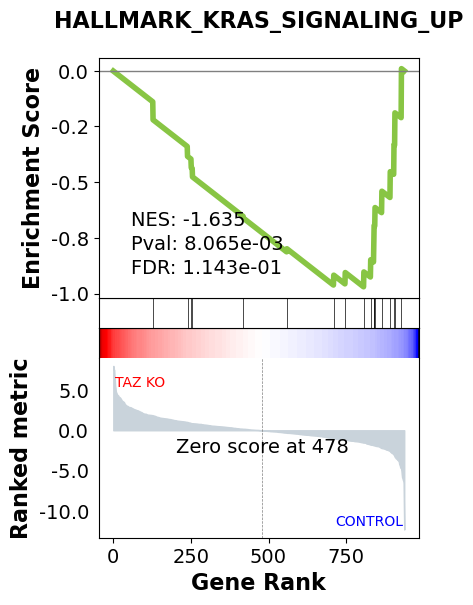

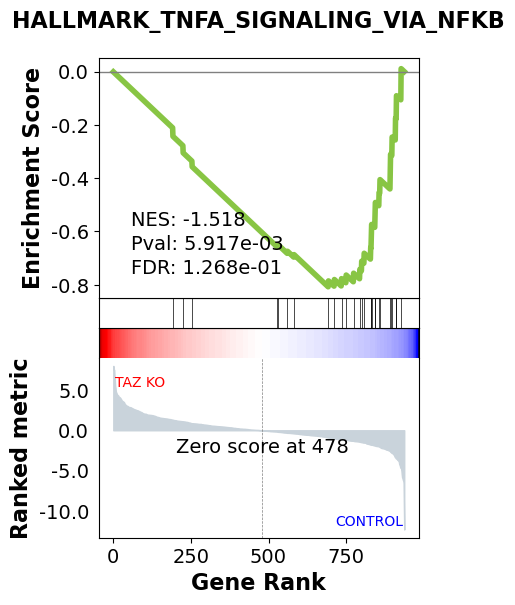

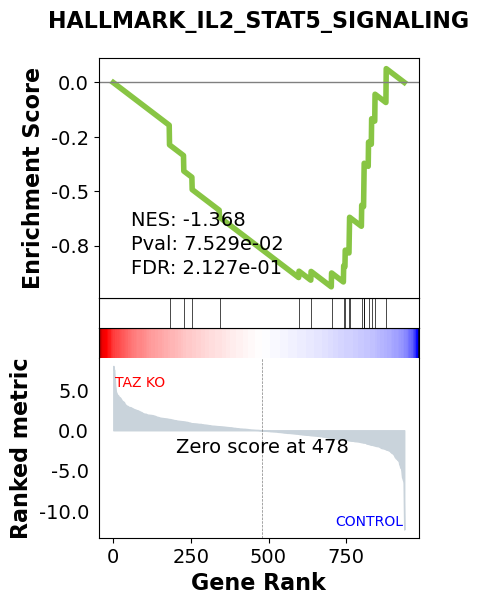

In [88]:
for i in gs_res.res2d.loc[gs_res.res2d['FDR q-val'] <= 0.25, 'Term']:
    fig = gs_res.plot(i)
    fig.set_size_inches(4,6)

<h1>Exercise #6: Run GSEA on genes that do not overlap with our ChIP-seq peaks</h1>

For this last exercise, practice running GSEA on our RNA-seq genes that were found to not overlap with our ChIP-seq genes, and after, we can take a look at what the result might tell us about the indirect targets of TAZ.

In [89]:
no_overlap_counts = no_overlap.merge(counts,
                               how='inner',
                               on='gene'
                              )

In [90]:
no_overlap_counts

,gene,1M_g1_control,1M_g1_tazko,1M_g2_control,1M_g2_tazko,1M_g3_control,1M_g3_tazko,1M_g4_control,1M_g4_tazko,1M_g5_control,1M_g5_tazko,1M_g6_control,1M_g6_tazko,1M_g7_control,1M_g7_tazko,1M_g8_control,1M_g8_tazko
0,MIR3682,10.864488,11.473588,13.387345,18.627580,22.981626,20.225662,7.723688,12.953005,10.870839,16.330359,18.358959,18.884246,15.897597,28.556184,22.954717,26.546993
1,HILPDA,335.811463,467.769373,310.586403,519.243798,331.419241,449.780201,360.806580,439.224637,324.452746,438.470148,378.774318,568.515193,451.094328,561.604948,366.127731,490.627752
2,PKD1P3,6.913765,7.943254,12.494855,10.478014,14.514711,17.336282,5.516920,5.887730,10.034621,7.348662,8.696349,7.951261,3.974399,7.614982,16.068302,12.781885
3,CAPNS1,9498.525986,9871.698940,10191.339487,10774.890915,10684.037080,9770.921070,9881.907445,10440.122345,10299.702239,9630.012899,10930.344604,11811.598860,11988.775692,11194.024054,10316.997416,11363.096055
4,LOC100420644,24.692019,28.242679,33.022118,29.105594,24.191186,48.156338,30.894753,30.616195,38.466047,25.312057,36.717919,45.719753,17.884797,9.518728,67.716414,41.295322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20579,USP54,1002.495984,908.178651,1087.052412,963.977275,920.474609,950.606121,984.218562,833.702529,939.073282,870.408152,937.273185,869.669219,860.457463,973.765868,936.552441,883.916531
20580,IGKC,30.618104,1.765167,38.377056,11.642238,42.334575,8.668141,47.445514,5.887730,35.121174,6.532144,39.616702,6.957354,58.622391,3.807491,34.432075,4.916110
20581,AP3B1,3752.199254,3758.041492,3619.045592,3715.038024,3714.556535,3752.341891,4216.030410,3716.335001,3737.896323,3922.552312,3501.729919,3497.561123,3904.847379,3622.827853,3665.868255,3367.535172
20582,LOC105369747,3.950723,5.295502,6.247428,0.000000,6.047796,0.963127,11.033840,1.177546,8.362184,0.000000,12.561393,0.993908,0.000000,1.903746,2.295472,1.966444


In [91]:
gs_res_1 = gp.GSEA(data=no_overlap_counts,
                 gene_sets=hallmark_db,
                 classes=class_vector,
                 method='signal_to_noise',
                 permutation_type='phenotype',
                 permutation_num=1000,
                 seed=135
                )

gs_res_1.pheno_pos = tazko
gs_res_1.pheno_neg = ctrl
gs_res_1.run()

/srv/conda/lib/python3.11/site-packages/gseapy/plot.py:322: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(figsize=self.figsize, facecolor="white")


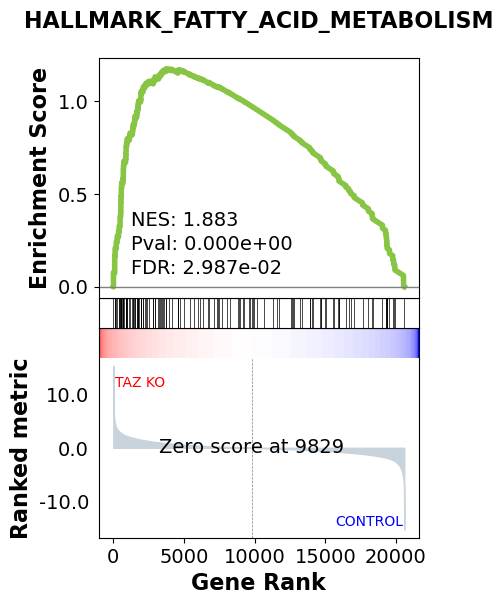

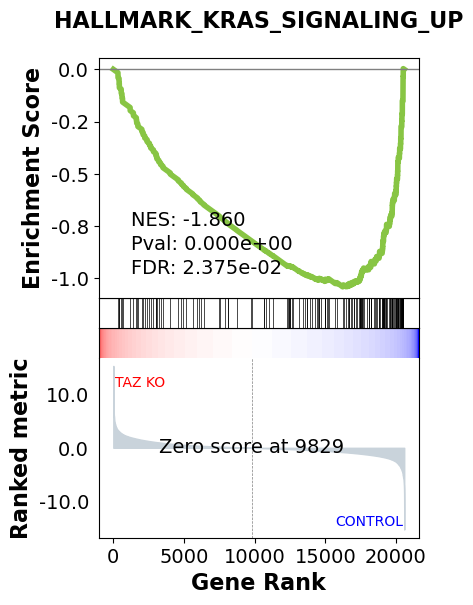

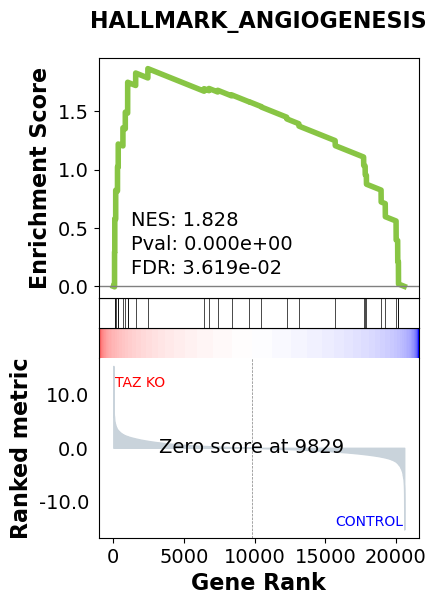

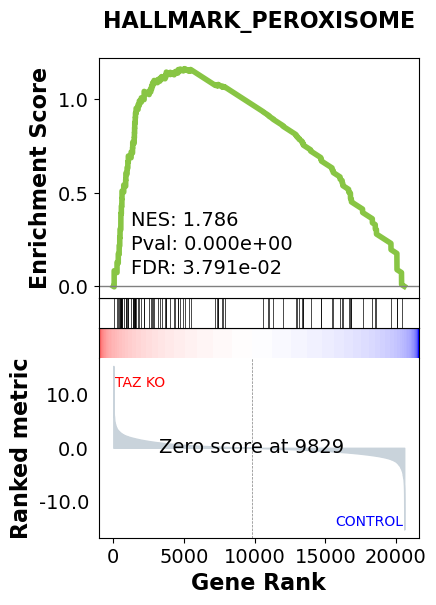

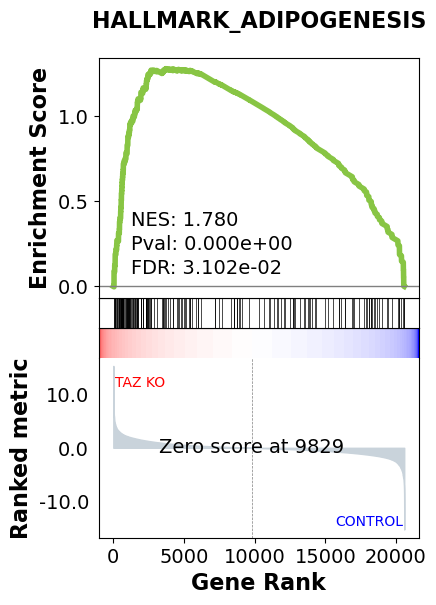

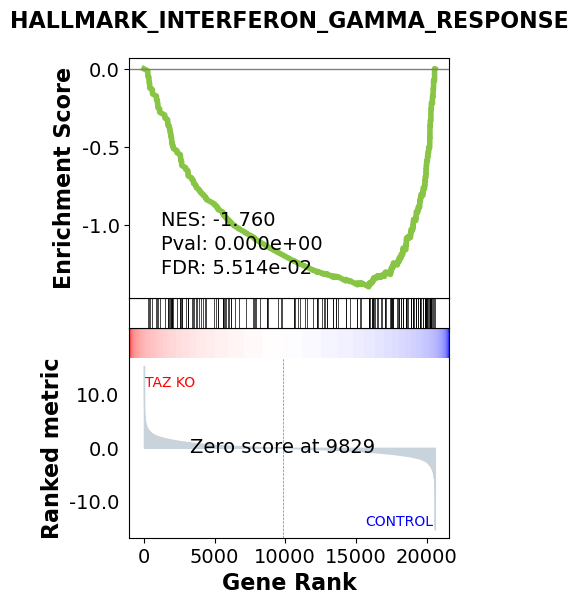

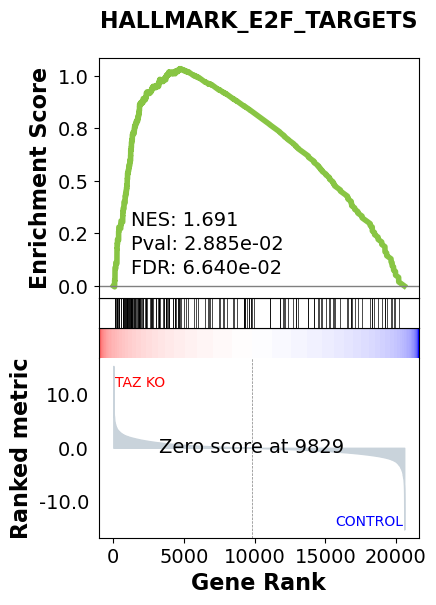

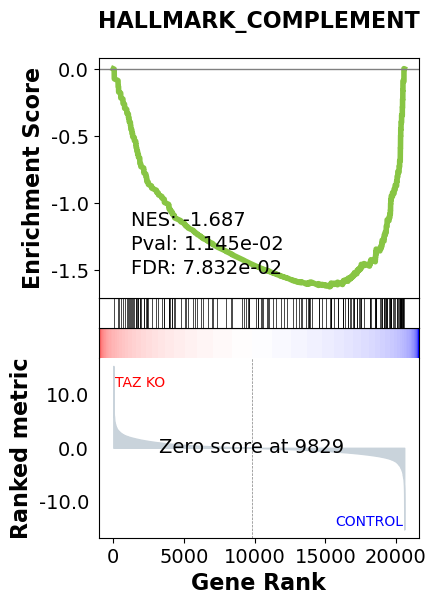

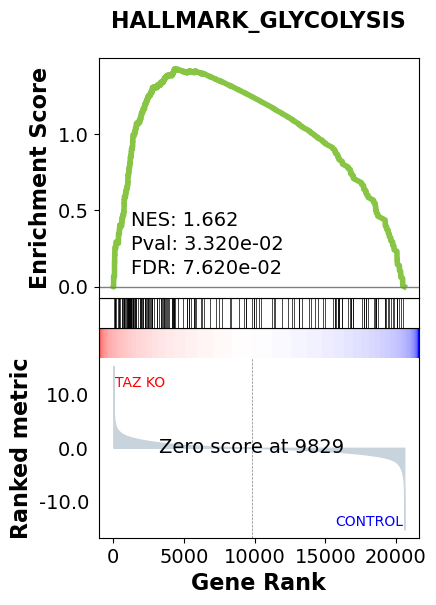

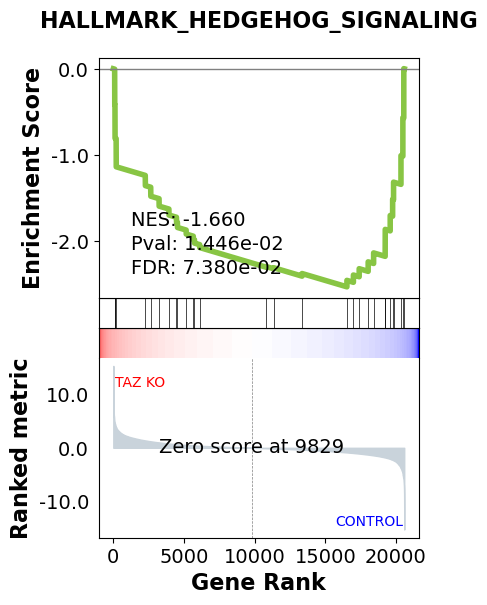

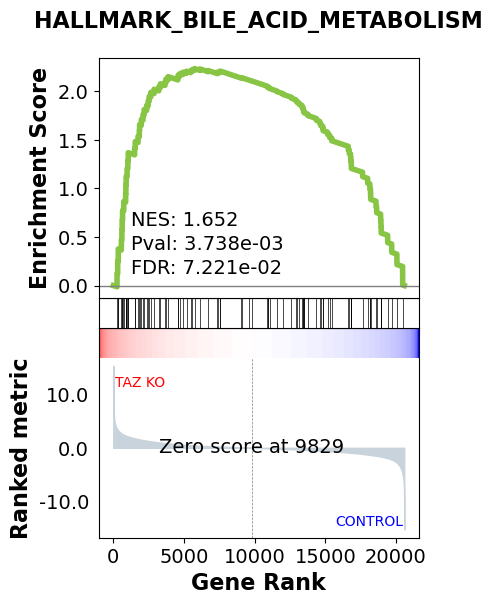

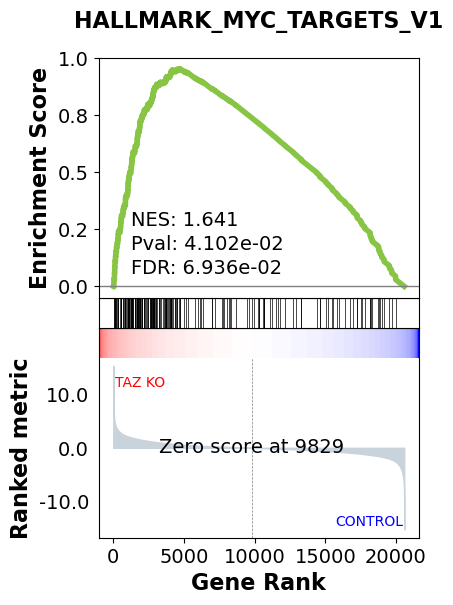

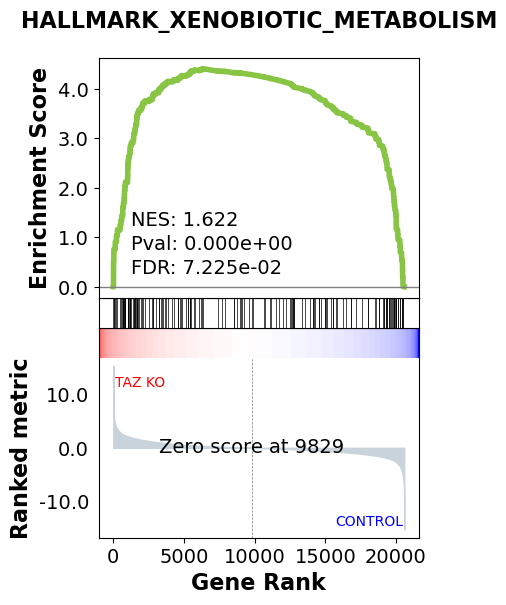

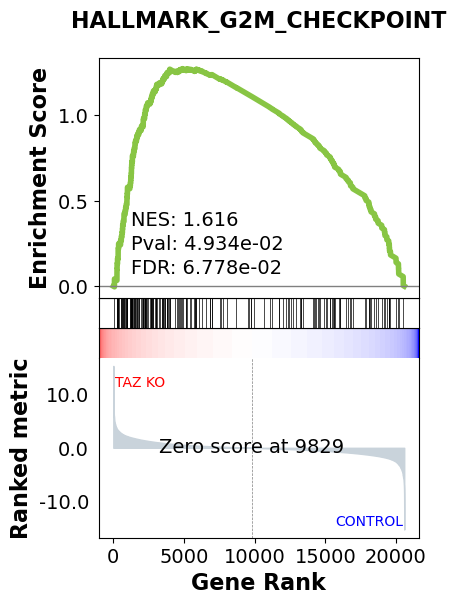

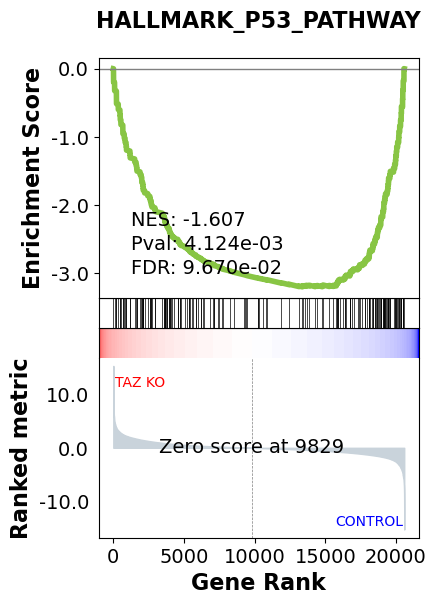

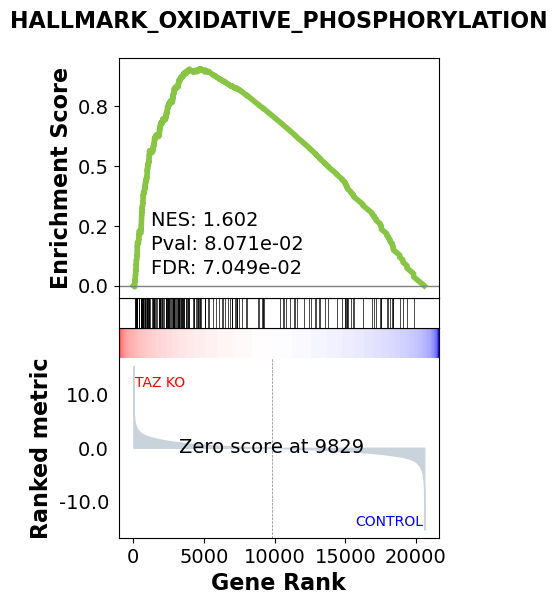

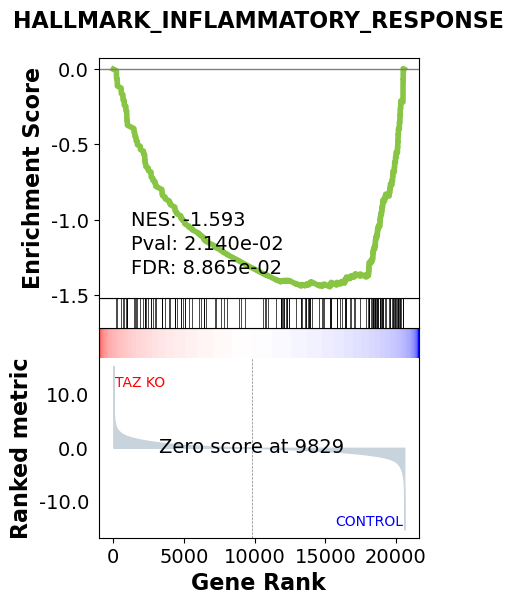

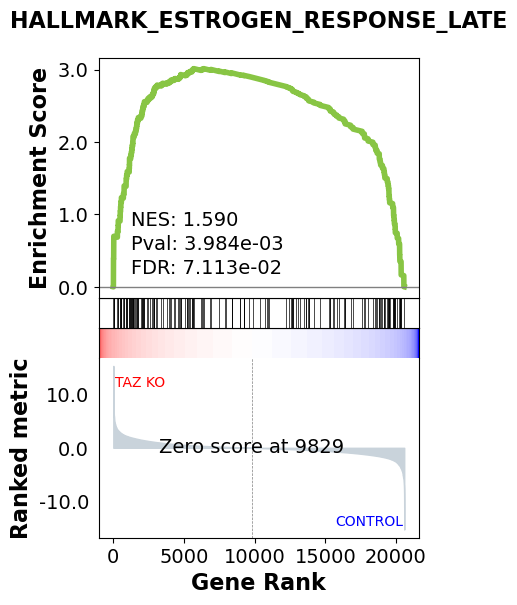

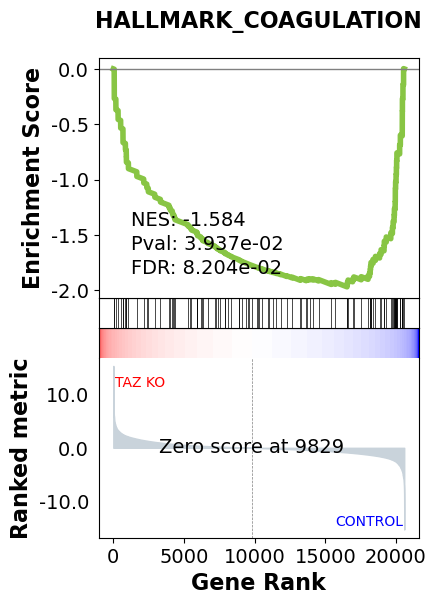

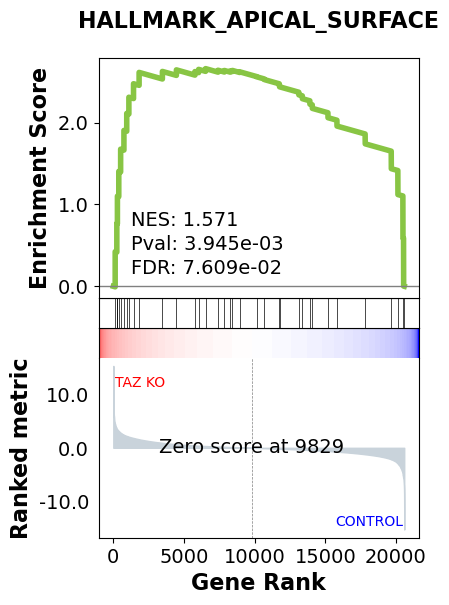

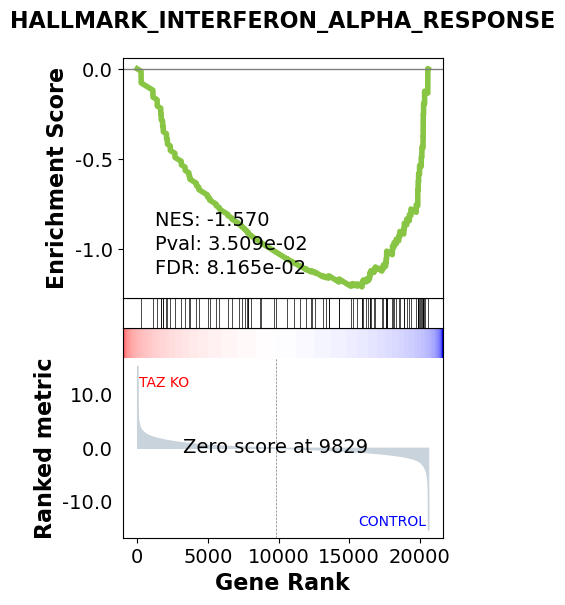

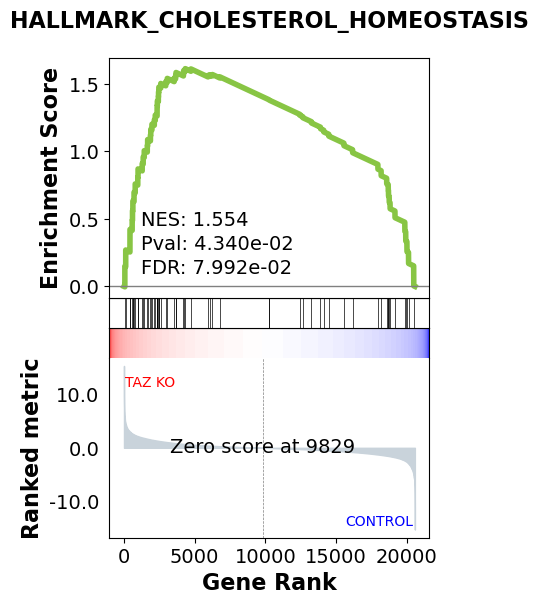

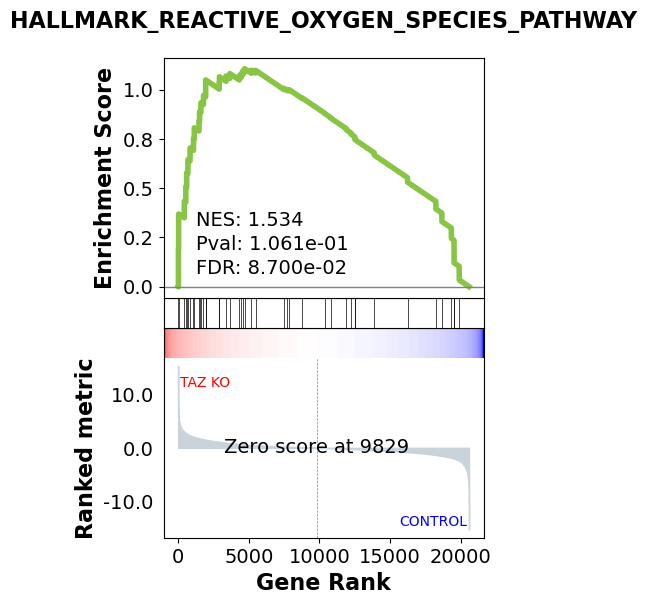

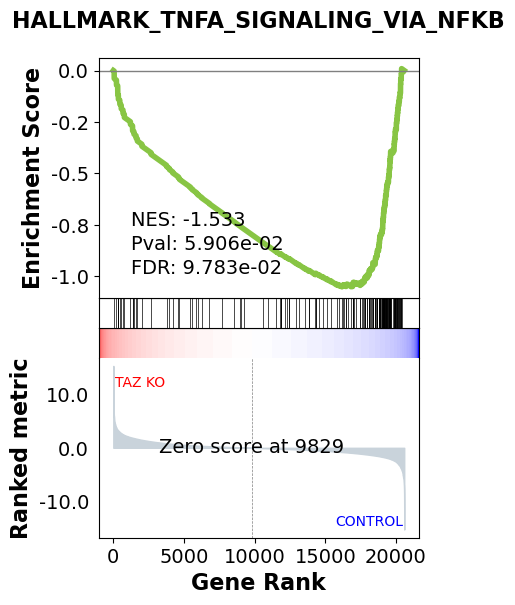

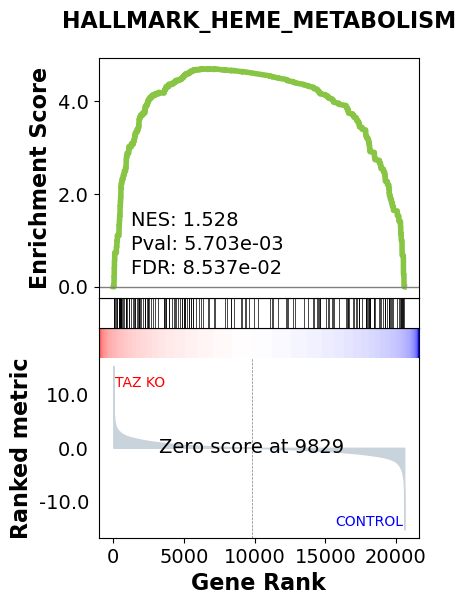

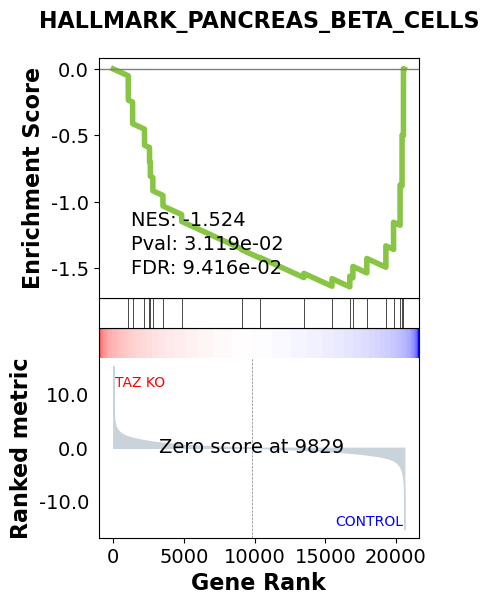

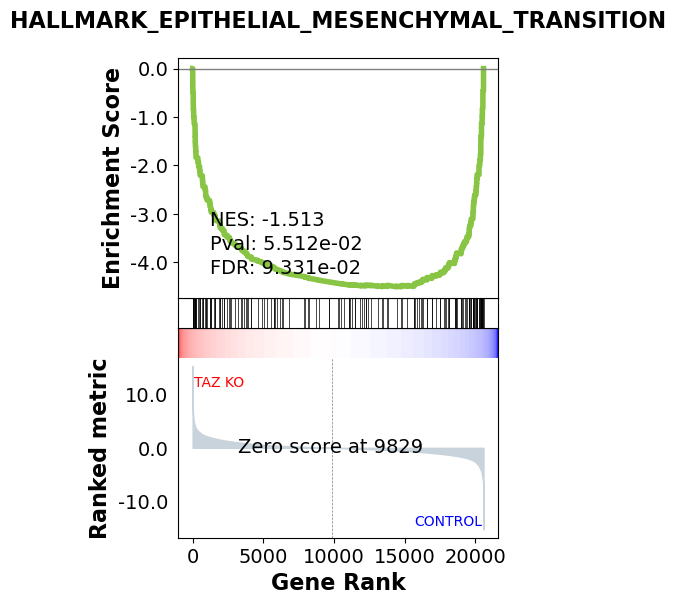

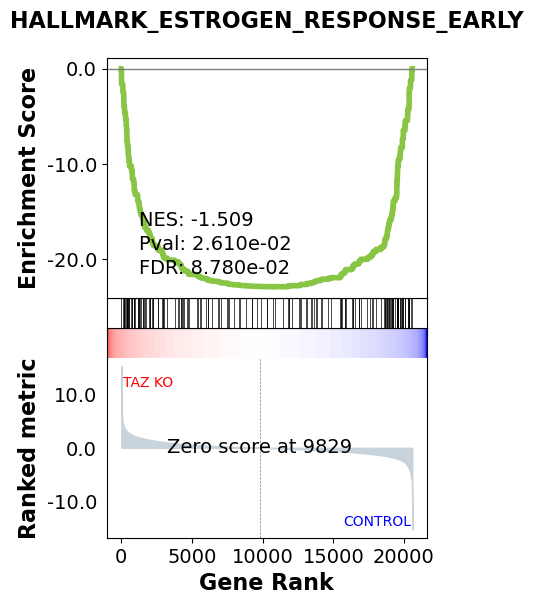

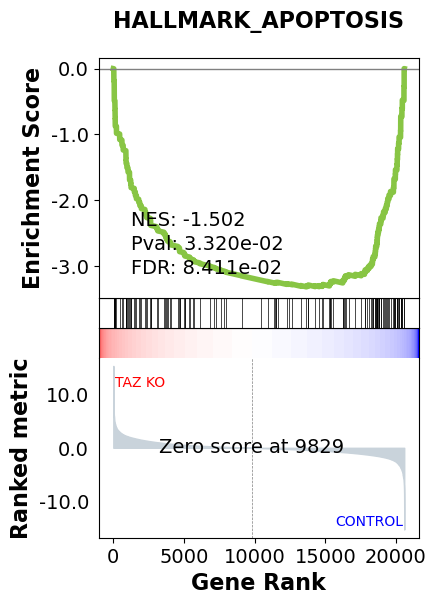

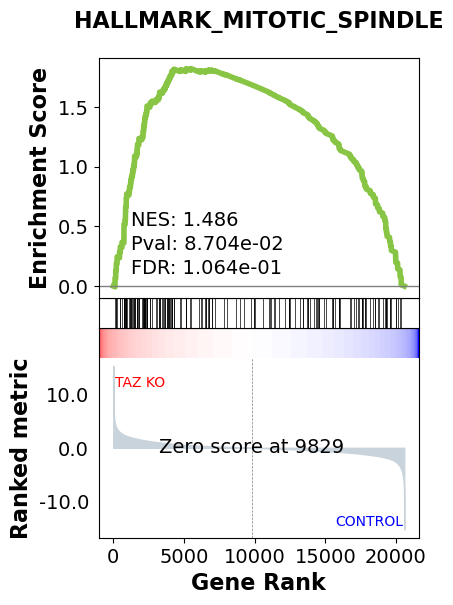

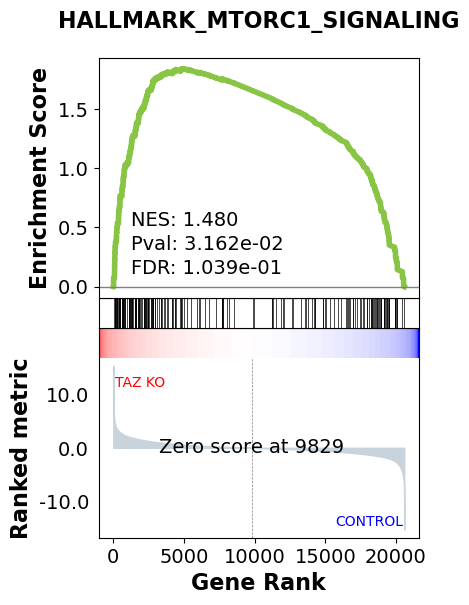

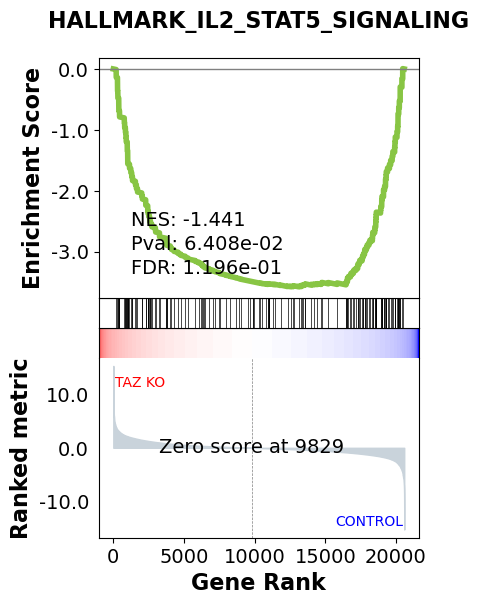

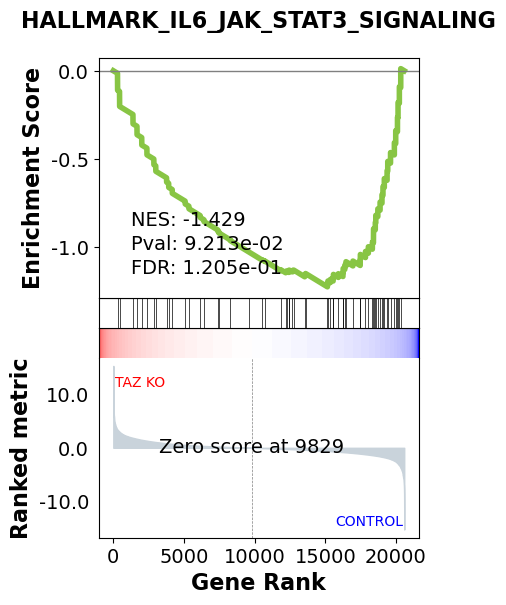

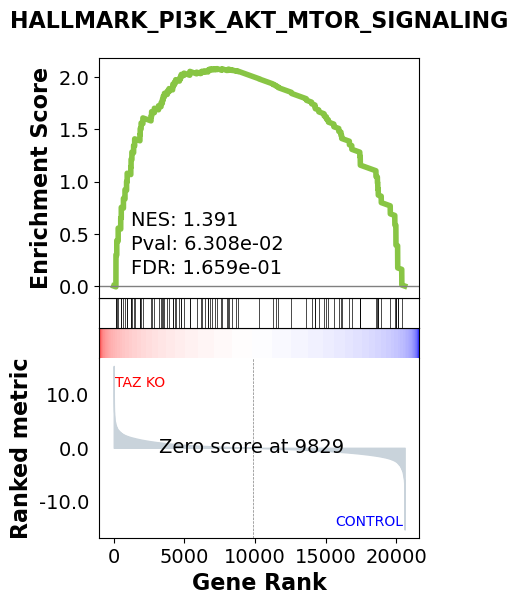

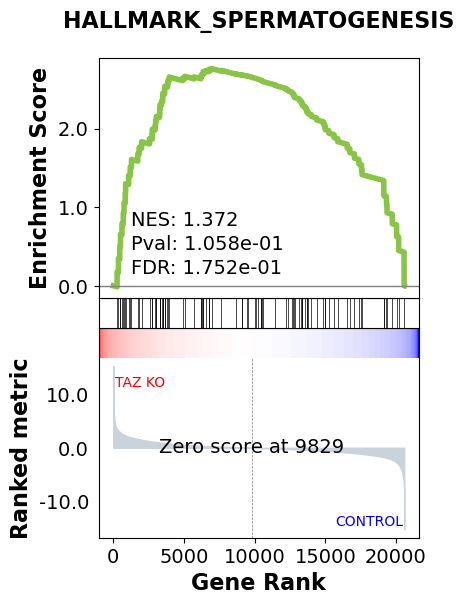

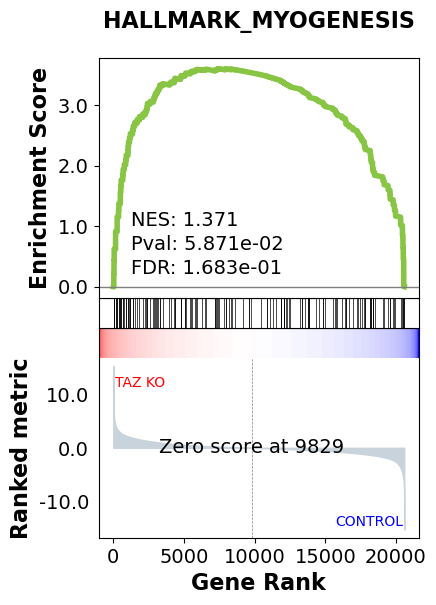

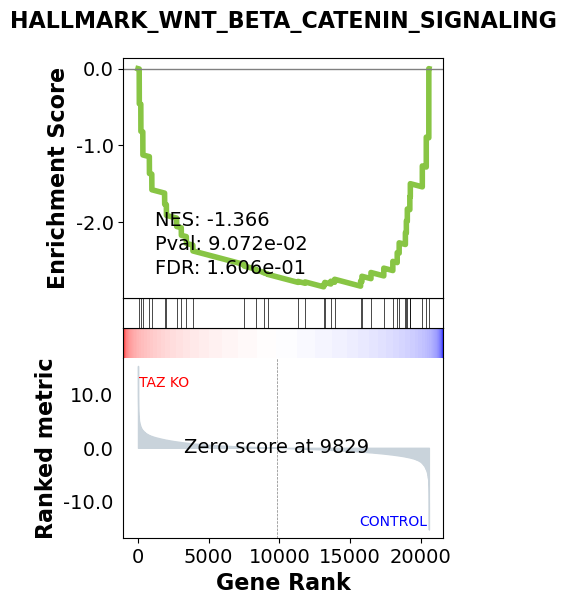

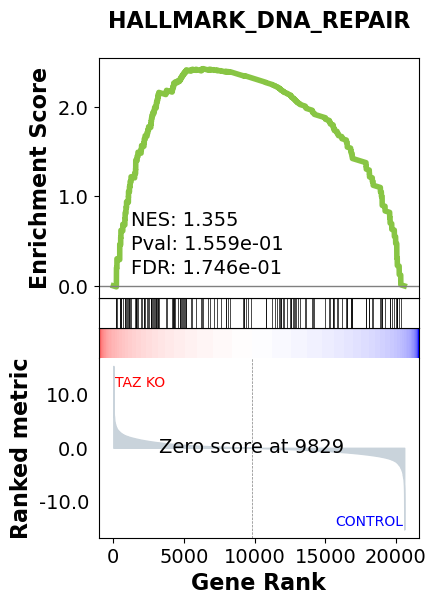

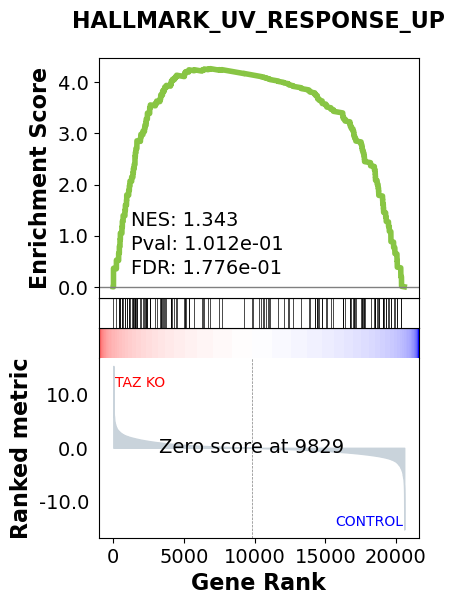

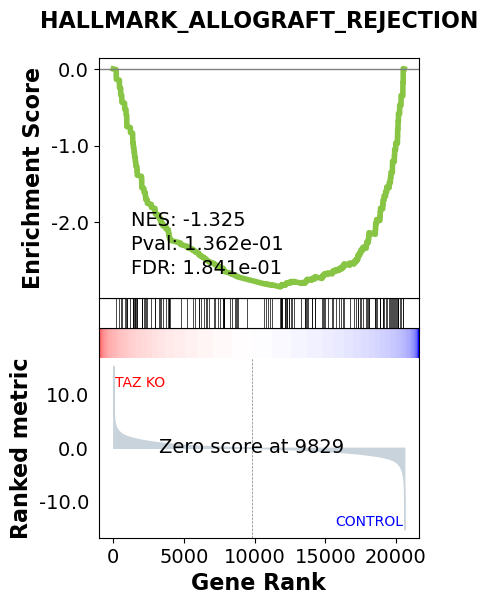

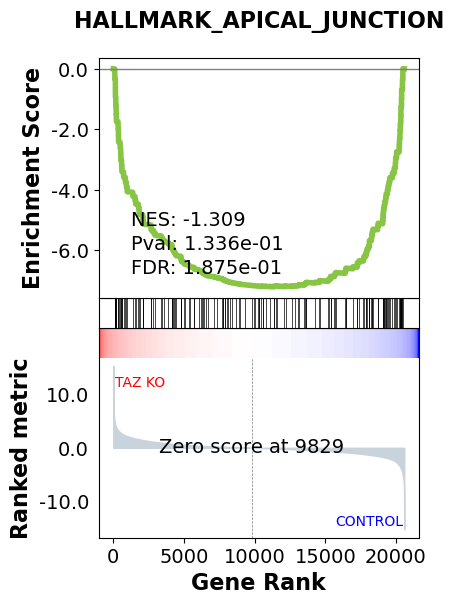

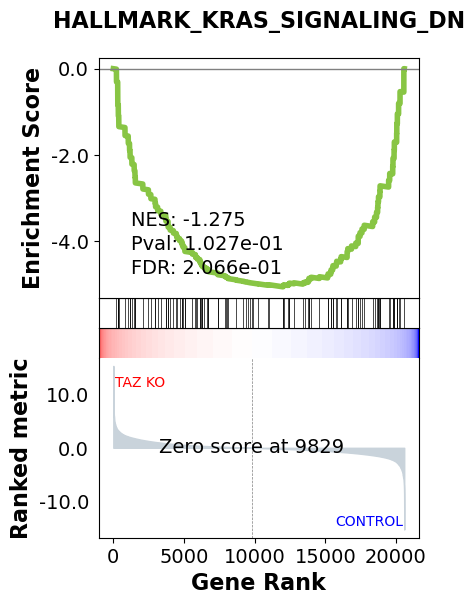

In [92]:
for i in gs_res_1.res2d.loc[gs_res_1.res2d['FDR q-val'] <= 0.25, 'Term']:
    fig = gs_res_1.plot(i)
    fig.set_size_inches(4,6)